In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
## follow the instructions on the website
def unpickle(file):
    ## used to read binary files since our data files are in binary format
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
data_1=unpickle('output_data_1.pickle')

In [4]:
data_2=unpickle('output_data_2.pickle')

In [5]:
data_3=unpickle('output_data_3.pickle')

In [6]:
data_4=unpickle('output_data_4.pickle')

In [7]:
data_5=unpickle('output_data_5.pickle')

In [8]:
data = np.concatenate((data_1,data_2,data_3,data_4,data_5),axis=0)

In [9]:
label =unpickle('output_label.pickle')

In [10]:
label.shape

(9074,)

In [11]:
type(data)

numpy.ndarray

In [12]:
total_count = data.shape[0]

In [13]:
total_count

9074

In [14]:
import math

In [15]:
train_count = math.ceil(total_count * 0.7)
val_count = math.ceil((total_count - train_count) * 0.5)
test_count = total_count - train_count - val_count
print(total_count, train_count, val_count, test_count)

9074 6352 1361 1361


In [16]:
X_train = data[:train_count]
y_train = label[:train_count]
X_val = data[train_count:(train_count+val_count)]
y_val = label[train_count:(train_count+val_count)]
X_test = data[(train_count+val_count):(train_count+val_count+test_count)]
y_test = label[(train_count+val_count):(train_count+val_count+test_count)]

In [17]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6352, 196608), (6352,), (1361, 196608), (1361,), (1361, 196608), (1361,))

In [18]:
# for RGB data we can simply divide by 255
X_train_normalized =  X_train / 255.0
# print (type(X_train_normalized.shape[0]))

X_val_normalized =  X_val / 255.0
X_test_normalized = X_test / 255.0

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim

class MLP(nn.Module):
    ## a very simple MLP model
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x = self.fc1(x)
        return x

In [20]:
# utility for getting prediction accuracy
def get_correct_and_accuracy(y_pred, y):
    # y_pred is the nxC prediction scores
    # give the number of correct and the accuracy
    n = y.shape[0]
    # find the prediction class label
    _ ,pred_class = y_pred.max(dim=1)
    correct = (pred_class == y).sum().item()
    return correct ,correct/n

In [21]:
# init network
mlp = MLP(196608, 5)
print('model structure: ',mlp)
# init optimizer
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
# set loss function
criterion = nn.CrossEntropyLoss()

model structure:  MLP(
  (fc1): Linear(in_features=196608, out_features=5, bias=True)
)


In [29]:
# prepare for mini-batch stochastic gradient descent
n_iteration = 30
batch_size = 128
n_train_data = X_train_normalized.shape[0]
n_batch = int(np.ceil(n_train_data/batch_size))



In [ ]:
# convert X_train and X_val to tensor and flatten them
X_train_tensor = torch.from_numpy(X_train_normalized).float()
X_val_tensor = torch.from_numpy(X_val_normalized).float()


# convert training label to tensor and to type long
y_train_tensor = torch.from_numpy(y_train).long()
y_val_tensor = torch.from_numpy(y_val).long()

# print (y_train_tensor.size())
# print (y_train_tensor.dtype)

In [30]:
X_train_tensor

tensor([[0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
        [0.5020, 0.5020, 0.5020,  ..., 0.5176, 0.5176, 0.5176],
        [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
        ...,
        [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
        [0.5020, 0.5020, 0.4980,  ..., 0.5020, 0.5020, 0.4980],
        [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020]])

In [31]:
y_train_tensor.shape

torch.Size([6352])

In [32]:
## start 
train_loss_list = np.zeros(n_iteration)
train_accu_list = np.zeros(n_iteration)
val_loss_list = np.zeros(n_iteration)
val_accu_list = np.zeros(n_iteration)
for i in range(n_iteration):
    # first get a minibatch of data
    running_loss = 0
    correct_train = 0
    for j in range(n_batch):
        batch_start_index = j*batch_size
        # get data batch from the normalized data
        X_batch = X_train_tensor[batch_start_index:batch_start_index+batch_size]
        # get ground truth label y
        y_batch = y_train_tensor[batch_start_index:batch_start_index+batch_size]
        # predict
        pred = mlp(X_batch)
        # calculate loss
        loss = criterion(pred, y_batch)
        running_loss += loss.item()
        # calculate correctly trained
        train_correct,train_accuracy = get_correct_and_accuracy(pred, y_batch)
        correct_train += train_correct
        
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ave_train_loss = running_loss/n_batch
    train_accu = correct_train/n_train_data
    pred_val = mlp(X_val_tensor)
    loss_val = criterion(pred_val, y_val_tensor)
    val_loss = loss_val.item()
    val_count,val_accu = get_correct_and_accuracy(pred_val,y_val_tensor)
    
    print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f" 
          %(i ,ave_train_loss, train_accu, val_loss, val_accu)) 
    
    ## add to the logs so that we can use them later for plotting
    train_loss_list[i] = ave_train_loss
    train_accu_list[i] = train_accu
    val_loss_list[i] = val_loss
    val_accu_list[i] = val_accu
    

Iter 0 ,Train loss: 75.535, Train acc: 0.419, Val loss: 32.634, Val acc: 0.306
Iter 1 ,Train loss: 52.765, Train acc: 0.452, Val loss: 37.193, Val acc: 0.302
Iter 2 ,Train loss: 36.925, Train acc: 0.488, Val loss: 6.524, Val acc: 0.431
Iter 3 ,Train loss: 43.863, Train acc: 0.444, Val loss: 10.946, Val acc: 0.405
Iter 4 ,Train loss: 40.141, Train acc: 0.449, Val loss: 8.377, Val acc: 0.528
Iter 5 ,Train loss: 89.397, Train acc: 0.445, Val loss: 22.367, Val acc: 0.315
Iter 6 ,Train loss: 154.683, Train acc: 0.391, Val loss: 19.862, Val acc: 0.340
Iter 7 ,Train loss: 169.941, Train acc: 0.379, Val loss: 44.651, Val acc: 0.289
Iter 8 ,Train loss: 212.504, Train acc: 0.345, Val loss: 39.589, Val acc: 0.309
Iter 9 ,Train loss: 286.013, Train acc: 0.312, Val loss: 31.251, Val acc: 0.444
Iter 10 ,Train loss: 213.855, Train acc: 0.345, Val loss: 42.460, Val acc: 0.464
Iter 11 ,Train loss: 222.117, Train acc: 0.362, Val loss: 31.967, Val acc: 0.458
Iter 12 ,Train loss: 260.693, Train acc: 0.345

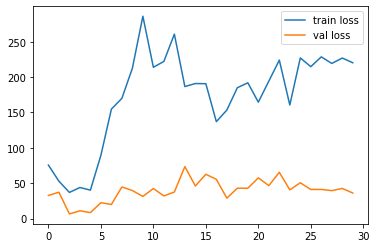

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
## plot training loss versus validation loss
x_axis = np.arange(n_iteration)
plt.plot(x_axis, train_loss_list, label='train loss')
plt.plot(x_axis, val_loss_list, label='val loss')
plt.legend()
plt.show()

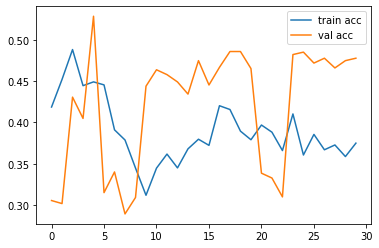

In [34]:
## plot training accuracy versus validation accuracy
plt.plot(x_axis, train_accu_list, label='train acc')
plt.plot(x_axis, val_accu_list, label='val acc')
plt.legend()
plt.show()

In [28]:
## test performance on the test set and report final performance

X_test_tensor = torch.from_numpy(X_test_normalized).float().reshape(X_test_normalized.shape[0],-1)
y_test_tensor = torch.from_numpy(y_test).long()
pred_test = mlp(X_test_tensor)
test_correct,test_acc = get_correct_and_accuracy(pred_test, y_test_tensor)

print("Test accuracy: ",test_acc )

Test accuracy:  0.5407788390889052
